![score2 table](https://www.louvainmedical.be/sites/default/files/content-site/Octobre2022/dmeuref-f1.jpg)

In [17]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/observations.db")

query = """
SELECT p.GENDER, t.smoker,cast(strftime('%Y.%m%d', date(l.date)) - strftime('%Y.%m%d', date(p.BIRTHDATE)) as INT) as age, l.ldl, s.sys
FROM patients p
JOIN (
    SELECT PATIENT, max(date(DATE)) as date, cast(VALUE as DECIMAL) / 18.018 as ldl
    FROM observations
    WHERE DESCRIPTION = 'Low Density Lipoprotein Cholesterol' AND UNITS = 'mg/dL'
    GROUP BY PATIENT
) l on p.Id = l.PATIENT
JOIN (
    SELECT PATIENT, max(date(DATE)) as date, cast(VALUE as INT) as sys
    FROM observations
    WHERE DESCRIPTION = 'Systolic Blood Pressure' AND UNITS = 'mm[Hg]'
    GROUP BY PATIENT
) s on p.Id = s.PATIENT
JOIN (
    SELECT PATIENT, max(date(DATE)) as date,
        CASE
            WHEN VALUE = 'Smokes tobacco daily (finding)' THEN 1
            WHEN VALUE = 'Ex-smoker (finding)' THEN 1
            WHEN VALUE = 'Never smoked tobacco (finding)' THEN 0
            ELSE 0
        END as smoker
    FROM observations
    WHERE DESCRIPTION = 'Tobacco smoking status'
    GROUP BY PATIENT
) t on p.Id = t.PATIENT;
"""

df = pd.read_sql(query, conn)

In [18]:
from lib.score2 import score2
score2('M', True, 49, 5.1, 159)

df2 = pd.DataFrame({
    'id': [],
    'gender': [],
    'smoker': [],
    'score2': []
})
id = 1
for index, row in df.iterrows():
    score = score2(row["GENDER"], row["smoker"], row["age"], row["ldl"], row["sys"])
    if score != -1:
        df2.loc[len(df2.index)] = [id, row["GENDER"], row["smoker"], score]
        id = id + 1

  gender  score2   id  smoker
0      F     1.0  198     198
1      F     2.0  256     256
2      F     3.0  165     165
3      F     4.0   77      77
4      F     5.0   85      85
5      F     6.0   52      52
6      F     7.0    7       7


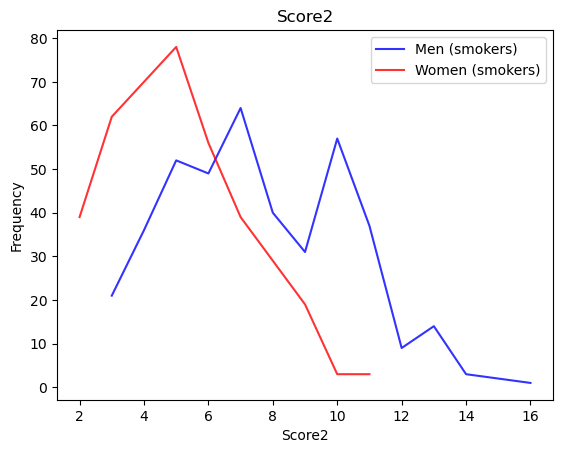

In [19]:
import matplotlib.pyplot as plt

wdf = df2.where(df2.gender == 'F').where(df2.smoker == 0).dropna().groupby(['gender', 'score2']).count().reset_index()
print(wdf)
mdf = df2.where(df2.gender == 'M').where(df2.smoker == 0).dropna().groupby(['gender', 'score2']).count().reset_index()
wsdf = df2.where(df2.gender == 'F').where(df2.smoker == 1).dropna().groupby(['gender', 'score2']).count().reset_index()
msdf = df2.where(df2.gender == 'M').where(df2.smoker == 1).dropna().groupby(['gender', 'score2']).count().reset_index()

# plt.bar(mdf["score2"], mdf["id"], width=0.9, align='center', label='Men (non smokers)', alpha=0.5, color='deepskyblue')
# plt.bar(wdf["score2"], wdf["id"], width=0.9, align='center', label='Women (non smokers)', alpha=0.5, color='orangered')
# plt.bar(msdf["score2"], msdf["id"], width=0.9, align='center', label='Men (smokers)', alpha=0.5, color='b')
# plt.bar(wsdf["score2"], wsdf["id"], width=0.9, align='center', label='Women (smokers)', alpha=0.5, color='r')

plt.plot(msdf["score2"], msdf["id"], label='Men (smokers)', alpha=0.8, color='b')
plt.plot(wsdf["score2"], wsdf["id"], label='Women (smokers)', alpha=0.8, color='r')
plt.xlabel('Score2')
plt.ylabel('Frequency')
plt.title('Score2')
plt.legend()
plt.show()

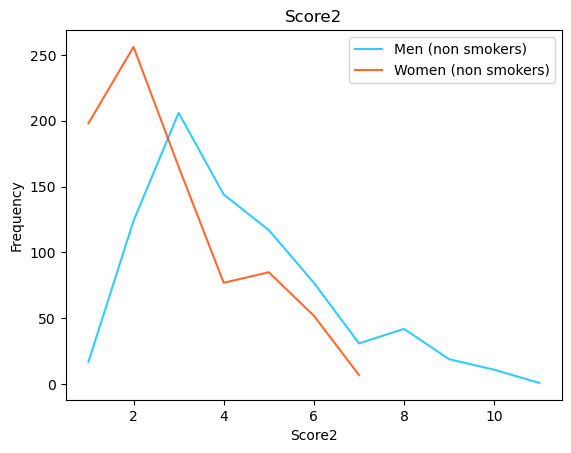

In [20]:
plt.plot(mdf["score2"], mdf["id"], label='Men (non smokers)', alpha=0.8, color='deepskyblue')
plt.plot(wdf["score2"], wdf["id"], label='Women (non smokers)', alpha=0.8, color='orangered')

plt.xlabel('Score2')
plt.ylabel('Frequency')
plt.title('Score2')
plt.legend()
plt.show()

Try with dp

In [21]:
from lib.score2 import score2
import numpy as np

score2('M', True, 49, 5.1, 159)

df3 = pd.DataFrame({
    'id': [],
    'gender': [],
    'smoker': [],
    'score2': []
})
id = 1
for index, row in df.iterrows():
    score = score2(row["GENDER"], row["smoker"], row["age"], row["ldl"], row["sys"])
    if score != -1:
        swag = df3.loc[len(df3.index)] = [id, row["GENDER"], row["smoker"], np.random.normal(score, 0.1)]
        print(swag)
        print(score, np.random.normal(score,0.1))
        id = id + 1

[1, 'F', 0, 0.8817454297428235]
1 0.9017372746729564
[2, 'F', 0, 2.890472574645913]
3 3.203863969092139
[3, 'M', 0, 1.8925914820225886]
2 1.8431738162348972
[4, 'F', 0, 1.925070905533352]
2 1.931326900335599
[5, 'F', 0, 6.0090593829725245]
6 6.0241979581903315
[6, 'F', 1, 7.9710548358536295]
8 8.116726477366075
[7, 'M', 1, 8.103867595818723]
8 8.021911239836616
[8, 'F', 0, 1.7439006462290503]
2 1.973457516109404
[9, 'F', 0, 3.147313123307092]
3 3.0961142445168637
[10, 'M', 0, 2.083822454402224]
2 1.9277233985862392
[11, 'F', 1, 4.890599578658606]
5 5.090821238115466
[12, 'M', 0, 4.822824838189293]
5 5.006908901809826
[13, 'F', 1, 7.047628988790954]
7 6.93013180972604
[14, 'F', 0, 3.902693545278254]
4 3.9150748536499393
[15, 'F', 0, 2.099008546751226]
2 2.1537425682036773
[16, 'F', 0, 1.9935894733461654]
2 2.1045459478084103
[17, 'F', 0, 3.002960318020474]
3 2.974308365567074
[18, 'F', 1, 3.1605753428628724]
3 2.903458756627048
[19, 'M', 1, 5.9000879480438595]
6 5.8329983053318815
[20, 

    gender    score2  id  smoker
0        F  0.739883   1       1
1        F  0.795265   1       1
2        F  0.805861   1       1
3        F  0.806073   1       1
4        F  0.807740   1       1
..     ...       ...  ..     ...
835      F  6.983152   1       1
836      F  6.987147   1       1
837      F  7.030558   1       1
838      F  7.048275   1       1
839      F  7.095950   1       1

[840 rows x 4 columns]


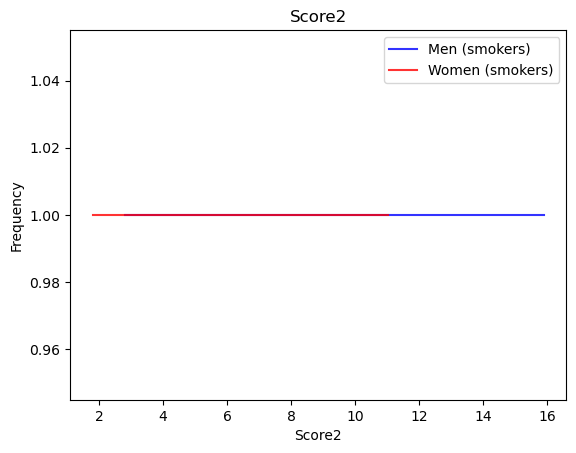

In [22]:
import matplotlib.pyplot as plt

wdf = df3.where(df3.gender == 'F').where(df3.smoker == 0).dropna().groupby(['gender', 'score2']).count().reset_index()
print(wdf)
mdf = df3.where(df3.gender == 'M').where(df3.smoker == 0).dropna().groupby(['gender', 'score2']).count().reset_index()
wsdf = df3.where(df3.gender == 'F').where(df3.smoker == 1).dropna().groupby(['gender', 'score2']).count().reset_index()
msdf = df3.where(df3.gender == 'M').where(df3.smoker == 1).dropna().groupby(['gender', 'score2']).count().reset_index()



plt.plot(msdf["score2"], msdf["id"], label='Men (smokers)', alpha=0.8, color='b')
plt.plot(wsdf["score2"], wsdf["id"], label='Women (smokers)', alpha=0.8, color='r')
plt.xlabel('Score2')
plt.ylabel('Frequency')
plt.title('Score2')
plt.legend()
plt.show()

Nonsmokers


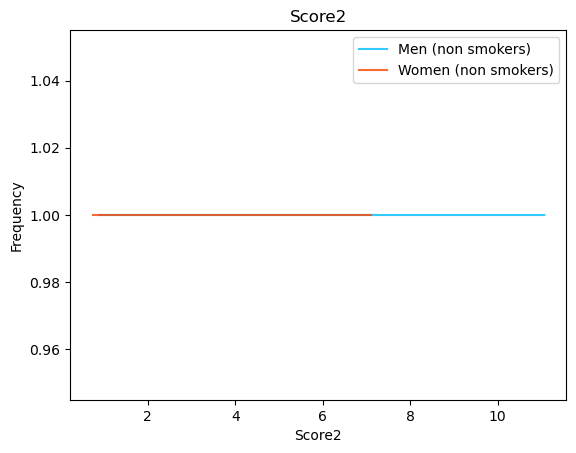

In [23]:
plt.plot(mdf["score2"], mdf["id"], label='Men (non smokers)', alpha=0.8, color='deepskyblue')
plt.plot(wdf["score2"], wdf["id"], label='Women (non smokers)', alpha=0.8, color='orangered')

plt.xlabel('Score2')
plt.ylabel('Frequency')
plt.title('Score2')
plt.legend()
plt.show()